# **Advanced Agent Architectures: 4 Key Patterns**

In this lab, we explore four distinct agent architectures using real-world use cases:
1. **Router (Tool Use):** A Personal Assistant that decides *which* tool to use (e.g., Calendar vs. Email).
2. **Sequential Handoffs (Chain):** A Research Agent that follows a strict Plan -> Search -> Summarize workflow.
3. **Parallelization:** An Automated News Aggregator that scrapes multiple sources simultaneously.
4. **Orchestrator-Workers:** A "Chief of Staff" agent delegating complex sub-tasks to specialized workers (Coder vs. Writer).

We will leverage the **Agno** framework and **Arize Phoenix** for tracing.

In [ ]:
!pip install -qqqqqq arize-otel agno openai openinference-instrumentation-agno openinference-instrumentation-openai httpx nest_asyncio

## 🔐 Account Setup & API Keys

Before building your **Agentic Flow**, you'll need API access for three key services:

- **[Arize AI](https://arize.com/signup/)** — for tracing, metrics, and observability  
- **[Tavily](https://tavily.com/)** — for search and web scraping  
- **[OpenAI](https://platform.openai.com/signup)** — for LLM inference (e.g., GPT-4o)

Once registered, collect your API keys from each platform’s dashboard.  
To keep credentials secure and reusable across sessions, we'll store them as **environment variables**.

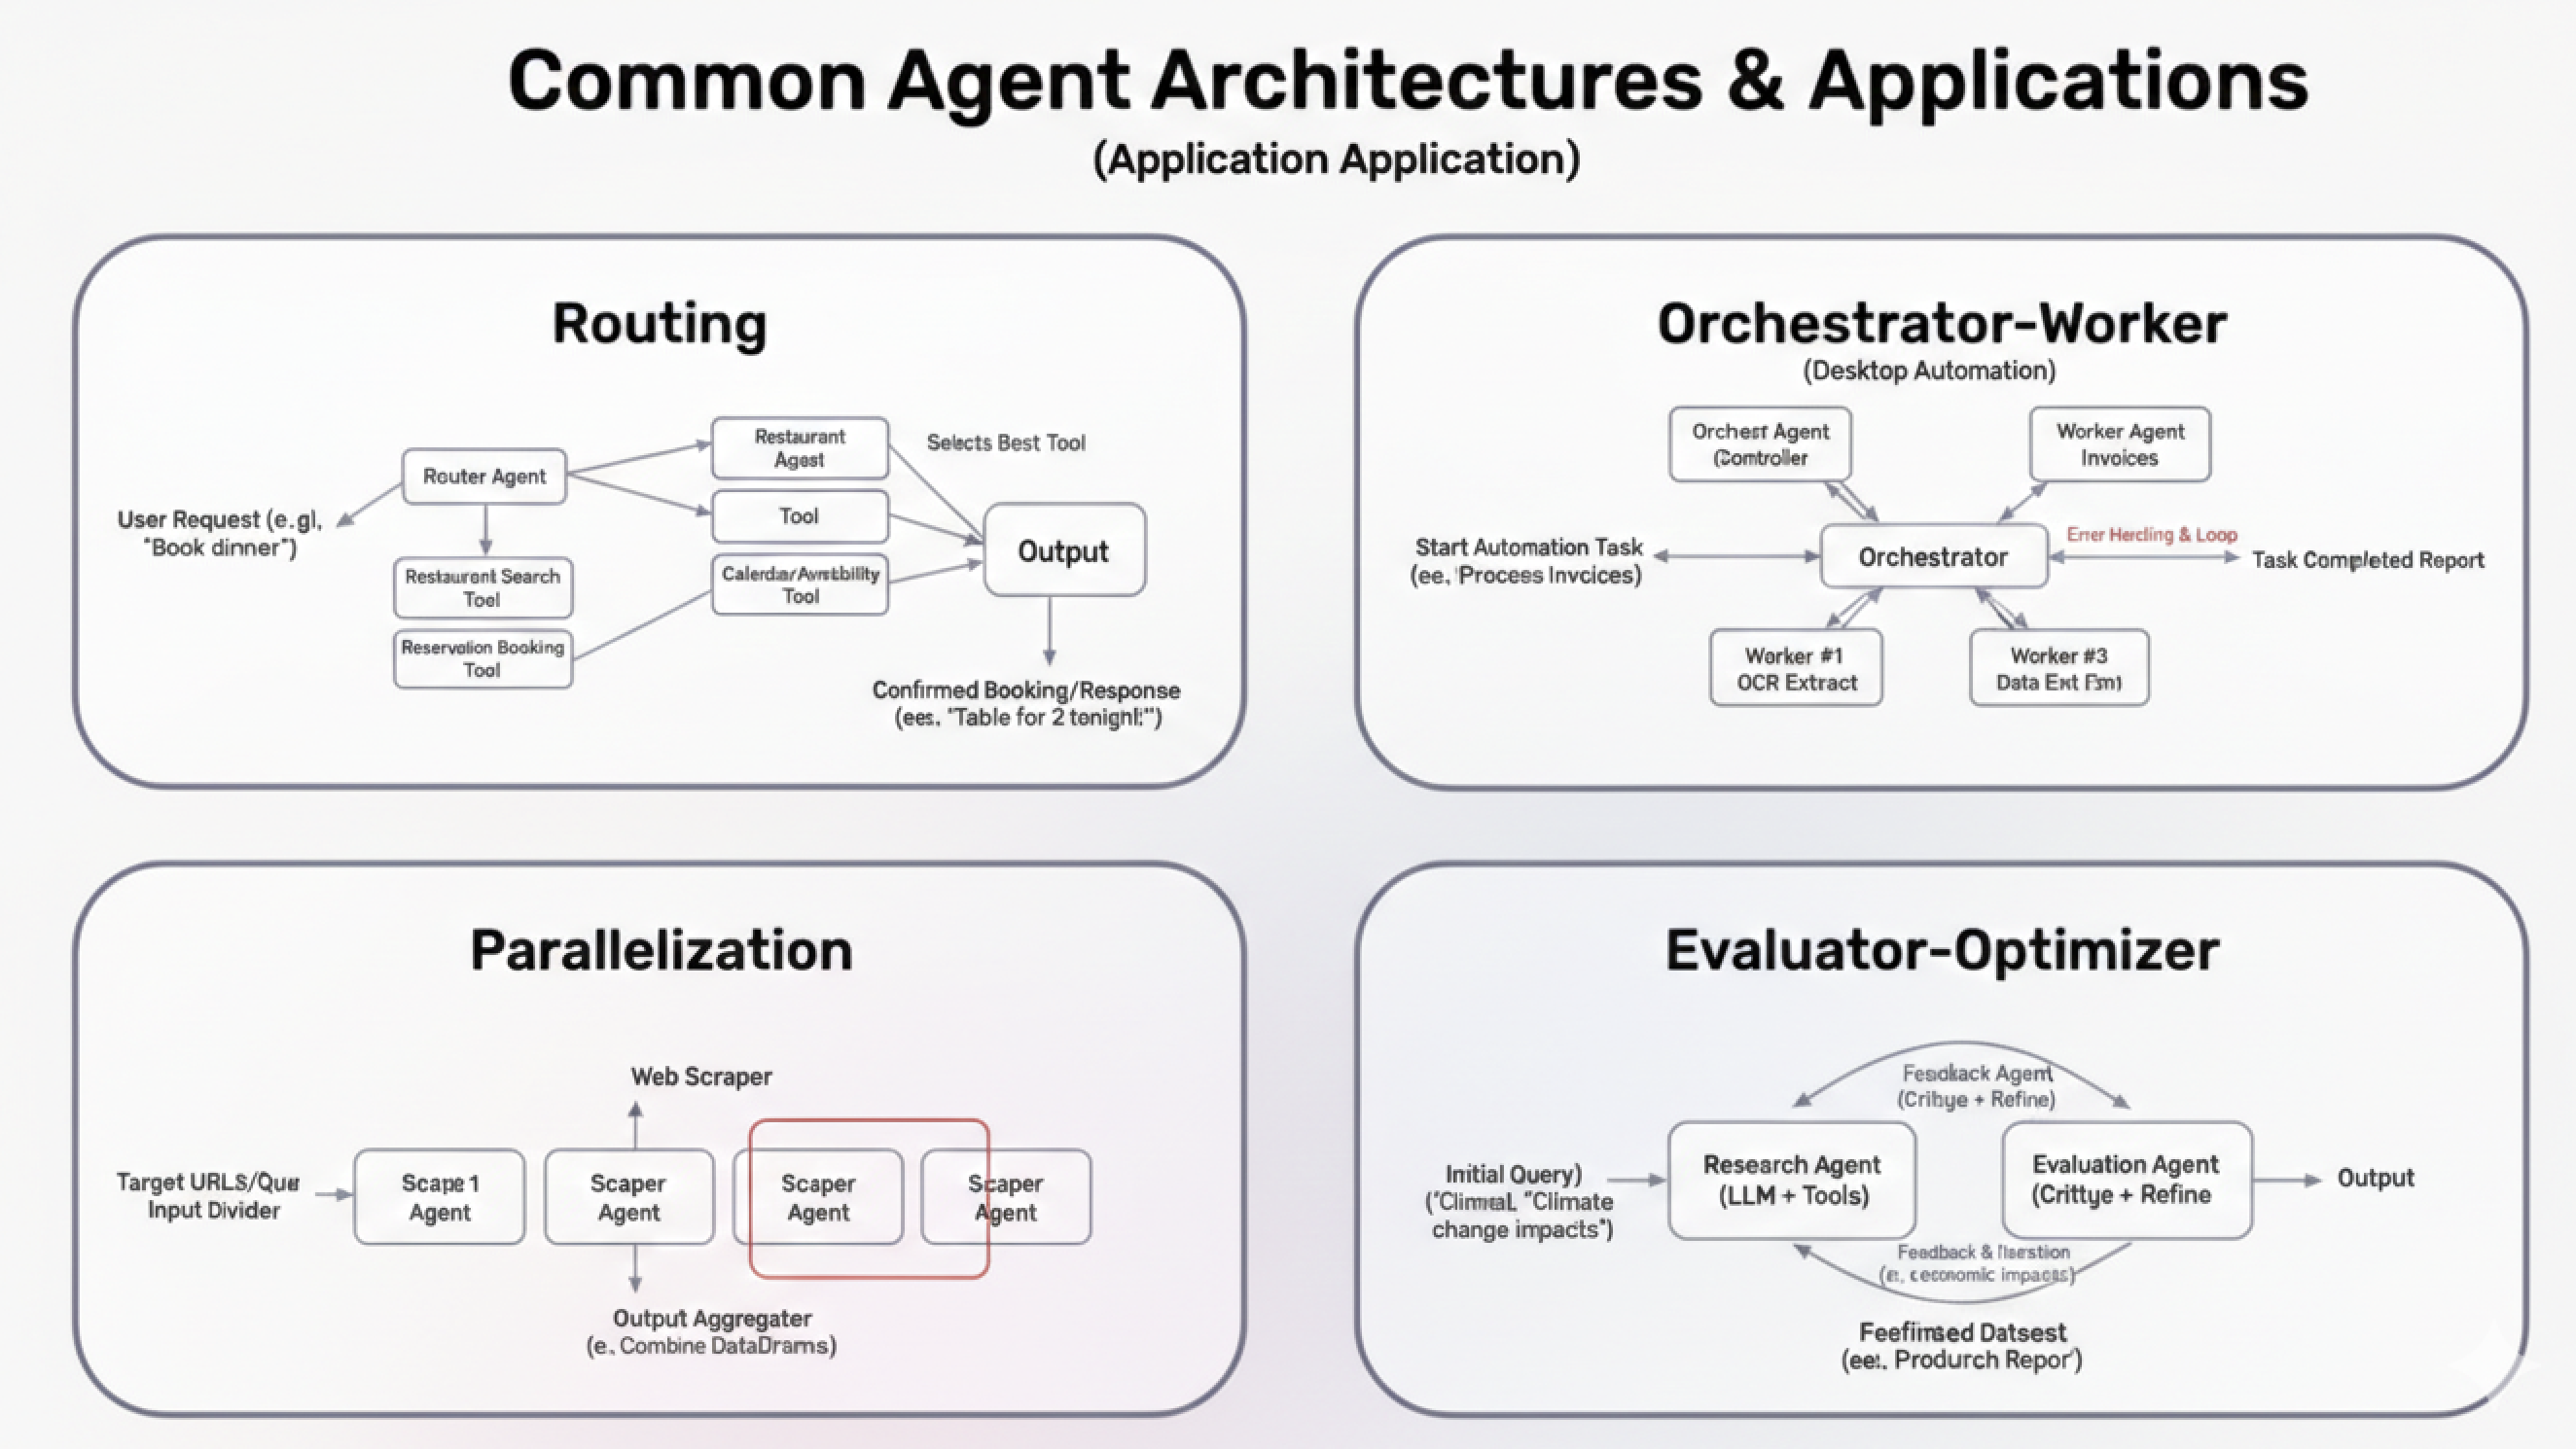

In [ ]:
import os
from getpass import getpass
import nest_asyncio
nest_asyncio.apply()

# --- API Keys ---
os.environ["ARIZE_SPACE_ID"] = globals().get("ARIZE_SPACE_ID") or getpass("🔑 Enter your Arize Space ID: ")
os.environ["ARIZE_API_KEY"] = globals().get("ARIZE_API_KEY") or getpass("🔑 Enter your Arize API Key: ")
os.environ["OPENAI_API_KEY"] = globals().get("OPENAI_API_KEY") or getpass("🔑 Enter your OpenAI API Key: ")
os.environ["TAVILY_API_KEY"] = globals().get("TAVILY_API_KEY") or getpass("🔑 Enter your Tavily API Key: ")

In [3]:
from arize.otel import register
from openinference.instrumentation.openai import OpenAIInstrumentor
from openinference.instrumentation.agno import AgnoInstrumentor

model_id = "agent-architecture-demo"
tracer_provider = register(
    space_id=os.getenv("ARIZE_SPACE_ID"),
    api_key=os.getenv("ARIZE_API_KEY"),
    project_name=model_id,
    set_global_tracer_provider=True
)
OpenAIInstrumentor().instrument(tracer_provider=tracer_provider)
AgnoInstrumentor().instrument(tracer_provider=tracer_provider)

🔭 OpenTelemetry Tracing Details 🔭
|  Arize Project: agent-architecture-demo
|  Span Processor: BatchSpanProcessor
|  Collector Endpoint: otlp.arize.com
|  Transport: gRPC
|  Transport Headers: {'authorization': '****', 'api_key': '****', 'arize-space-id': '****', 'space_id': '****', 'arize-interface': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



### **Define Simulation Tools**
We will mock some tools (Calendar, Email, Search) to simulate real-world actions without needing actual auth credentials.

In [4]:
from agno.tools import tool
import random
import time

# --- Personal Assistant Tools ---
@tool
def check_calendar(date: str) -> str:
    """Checks the user's calendar for a specific date."""
    return f"[Calendar] On {date}: 10:00 AM Team Sync, 2:00 PM Client Call."

@tool
def send_email(recipient: str, subject: str, body: str) -> str:
    """Sends an email to a recipient."""
    return f"[Email] Sent to {recipient}: '{subject}'"

# --- Research Tools ---
@tool
def search_web(query: str) -> str:
    """Simulates a web search for research."""
    # In production, use Tavily or Serper here
    return f"[Search Result for '{query}']: Recent studies show AI agent adoption is increasing by 40% annually."

@tool
def scrape_url(url: str) -> str:
    """Simulates scraping a specific URL."""
    return f"[Scrape {url}]: Content regarding advanced neural architectures and optimization techniques."

# --- Desktop Automation Tools ---
@tool
def run_python_script(script_name: str) -> str:
    """Executes a python script locally."""
    return f"[System] Executed {script_name}. Output: Process completed successfully."

@tool
def file_system_scan(directory: str) -> str:
    """Scans a directory for files."""
    return f"[File System] Found 3 files in {directory}: report.pdf, data.csv, notes.txt"

## **Architecture 1: The Router (Personal Assistant)**
**Use Case:** A Personal Assistant that handles varied requests (Scheduling vs. Communication).

**Pattern:** The LLM acts as a classifier/router. It analyzes the intent and picks the single best tool or path.

**Diagram:** `User Query -> Router -> [Tool A OR Tool B] -> Response`

In [7]:
from agno.agent import Agent
from agno.models.openai import OpenAIChat

personal_assistant = Agent(
    name="PersonalAssistant",
    model=OpenAIChat(id="gpt-4o"),
    description="A helpful assistant that manages your digital life.",
    instructions=[
        "You are a router. Determine if the user needs calendar help or email help.",
        "If asked about schedule, use check_calendar.",
        "If asked to message someone, use send_email.",
        "Reply concisely."
    ],
    tools=[check_calendar, send_email],
    
)

# --- Test Cases ---
print("--- Test 1: Calendar ---")
personal_assistant.print_response("What am I doing on Friday?")

print("\n--- Test 2: Email ---")
personal_assistant.print_response("Email Sarah that I'm running late for the 2pm meeting.")

--- Test 1: Calendar ---


Output()


--- Test 2: Email ---


Output()

## **Architecture 2: Sequential Handoffs (Deep Research)**
**Use Case:** A Research Agent that performs a multi-step workflow: Plan -> Search -> Summarize.

**Pattern:** The output of one agent becomes the input of the next. This ensures a strict order of operations, preventing the "jumping to conclusions" problem.

**Diagram:** `Planner -> Searcher -> Writer`

In [8]:
# 1. Planner Agent: Breaks down the topic
planner = Agent(
    name="Planner",
    model=OpenAIChat(id="gpt-4o"),
    instructions=["Break the research topic into 3 specific search queries. Return ONLY the queries as a bulleted list."]
)

# 2. Researcher Agent: Executes the search
researcher = Agent(
    name="Researcher",
    model=OpenAIChat(id="gpt-4o"),
    tools=[search_web],
    instructions=["Take the queries, search for each one, and return the raw findings."]
)

# 3. Writer Agent: Synthesizes
writer = Agent(
    name="Writer",
    model=OpenAIChat(id="gpt-4o"),
    instructions=["Write a professional executive summary based ONLY on the provided research findings."]
)

def run_research_pipeline(topic: str):
    print(f"--- Starting Research on: {topic} ---")
    
    # Step 1: Plan
    plan_response = planner.run(f"Plan research for: {topic}")
    print(f"[Plan]:\n{plan_response.content}\n")
    
    # Step 2: Research (Handoff Plan -> Researcher)
    findings_response = researcher.run(f"Execute this search plan:\n{plan_response.content}")
    print(f"[Findings]:\n{findings_response.content}\n")
    
    # Step 3: Write (Handoff Findings -> Writer)
    final_report = writer.run(f"Summarize these findings:\n{findings_response.content}")
    print(f"[Final Report]:\n{final_report.content}")

run_research_pipeline("The future of Quantum Computing in Banking")

--- Starting Research on: The future of Quantum Computing in Banking ---
[Plan]:
- "Potential applications of quantum computing in the banking industry"
- "Impact of quantum computing on financial security and data encryption in banking"
- "Forecasting quantum computing advancements and integration in banking by 2030"

[Findings]:
Here are the raw findings from the searches:

1. **Potential applications of quantum computing in the banking industry**:
    - [Research finding]: Recent studies show AI agent adoption is increasing by 40% annually.

2. **Impact of quantum computing on financial security and data encryption in banking**:
    - [Research finding]: Recent studies show AI agent adoption is increasing by 40% annually.

3. **Forecasting quantum computing advancements and integration in banking by 2030**:
    - [Research finding]: Recent studies show AI agent adoption is increasing by 40% annually.

[Final Report]:
Executive Summary:

Recent research into the banking industry's te

## **Architecture 3: Parallelization (News Aggregator)**
**Use Case:** Automated Web Scraping & Summarization from multiple sources at once.

**Pattern:** Multiple identical or specialized agents run effectively at the same time (async) to speed up throughput. A final "Reducer" agent aggregates the results.

**Diagram:** `Distributor -> [Agent A | Agent B | Agent C] -> Aggregator`

In [9]:
import asyncio

# The worker agent that scrapes a single URL
scraper_agent = Agent(
    name="Scraper",
    model=OpenAIChat(id="gpt-4o"),
    tools=[scrape_url],
    instructions=["Scrape the URL and extract key headlines."]
)

# The aggregator agent
editor_agent = Agent(
    name="Editor",
    model=OpenAIChat(id="gpt-4o"),
    instructions=["You are a News Editor. Combine the headlines from multiple sources into a single daily briefing."]
)

async def run_parallel_news_aggregator(urls):
    print(f"--- Parallel Scraping {len(urls)} sources ---")
    
    # Create async tasks for the scraper agent
    tasks = [scraper_agent.arun(f"Scrape this: {url}") for url in urls]
    
    # Run them all at once
    results = await asyncio.gather(*tasks)
    
    # Collect contents
    scraped_data = "\n\n".join([res.content for res in results])
    
    # Aggregation step
    final_brief = await editor_agent.arun(f"Create a briefing from these sources:\n{scraped_data}")
    print(f"\n[Daily Briefing]:\n{final_brief.content}")

# Mock URLs
news_sites = ["techcrunch.com", "bloomberg.com", "wired.com"]
await run_parallel_news_aggregator(news_sites)

--- Parallel Scraping 3 sources ---

[Daily Briefing]:
**Daily Tech and Business Briefing**

**Tech Innovations and Business Trends**

While there were technical difficulties accessing specific headlines today from TechCrunch and Bloomberg, here's a consolidated update using available information and general knowledge about current trends:

1. **Advancements in AI Neural Architectures**:
   - Novel techniques in neural architectures are pushing the boundaries of artificial intelligence. Optimization techniques are being enhanced to improve the efficiency and efficacy of neural models, driving innovations in tech sectors from natural language processing to autonomous systems.

2. **Global Tech Market Dynamics**:
   - While specific headlines were unavailable from Bloomberg, it's worthwhile to note the ongoing global shifts in tech markets. Companies are increasingly adopting AI-driven strategies to remain competitive, and geopolitical tensions continue to influence market dynamics and t

## **Architecture 4: Orchestrator-Workers (Desktop Automation)**
**Use Case:** Complex Desktop Action (e.g., "Analyze the data in my folder and write a script to fix it.")

**Pattern:** A central "Orchestrator" (Manager) breaks a complex goal into sub-tasks and assigns them to specialized workers (Coder, Analyst, FileSystem). The Manager maintains the state and decides the next step.

**Diagram:** `User -> Orchestrator <-> [File Agent, Coding Agent, Analyst Agent]`

In [10]:
from agno.team import Team

# --- specialized workers ---
file_agent = Agent(
    name="FileExplorer",
    tools=[file_system_scan],
    instructions=["Report files found in directories accurately."]
)

coder_agent = Agent(
    name="PythonDev",
    tools=[run_python_script],
    instructions=["Write and execute python scripts to manipulate data."]
)

analyst_agent = Agent(
    name="DataAnalyst",
    instructions=["Analyze text output and provide insights. Do not run code."]
)

# --- The Orchestrator (Team Lead) ---
# Agno's 'Team' class functions as an Orchestrator by default, 
# delegating to members based on the prompt.
desktop_automation_team = Team(
    name="Orchestrator",
    members=[file_agent, coder_agent, analyst_agent],
    model=OpenAIChat(id="gpt-4o"),
    instructions=[
        "You are a Desktop Automation Manager.",
        "1. Always check files first.",
        "2. If data needs processing, ask the PythonDev.",
        "3. Finally, ask the Analyst to summarize."
    ],
    show_members_responses=True
)

# --- Complex Task ---
task = "Check the '/documents' folder for data files, process the CSV found, and tell me what the trends are."
desktop_automation_team.print_response(task, stream=True)

INFO Agent 'FileExplorer' inheriting model from Team: gpt-4o

INFO Agent 'PythonDev' inheriting model from Team: gpt-4o

INFO Agent 'DataAnalyst' inheriting model from Team: gpt-4o

Output()

# **Conclusion & Tracing**
Check your Arize Phoenix dashboard to see the difference in traces:
1. **Router:** Flat trace (User -> Router -> Tool).
2. **Chain:** Deep, sequential trace (A -> B -> C).
3. **Parallel:** Wide trace (One parent span with multiple concurrent child spans).
4. **Orchestrator:** Recursive trace (Manager calling Worker A, getting result, then calling Worker B).

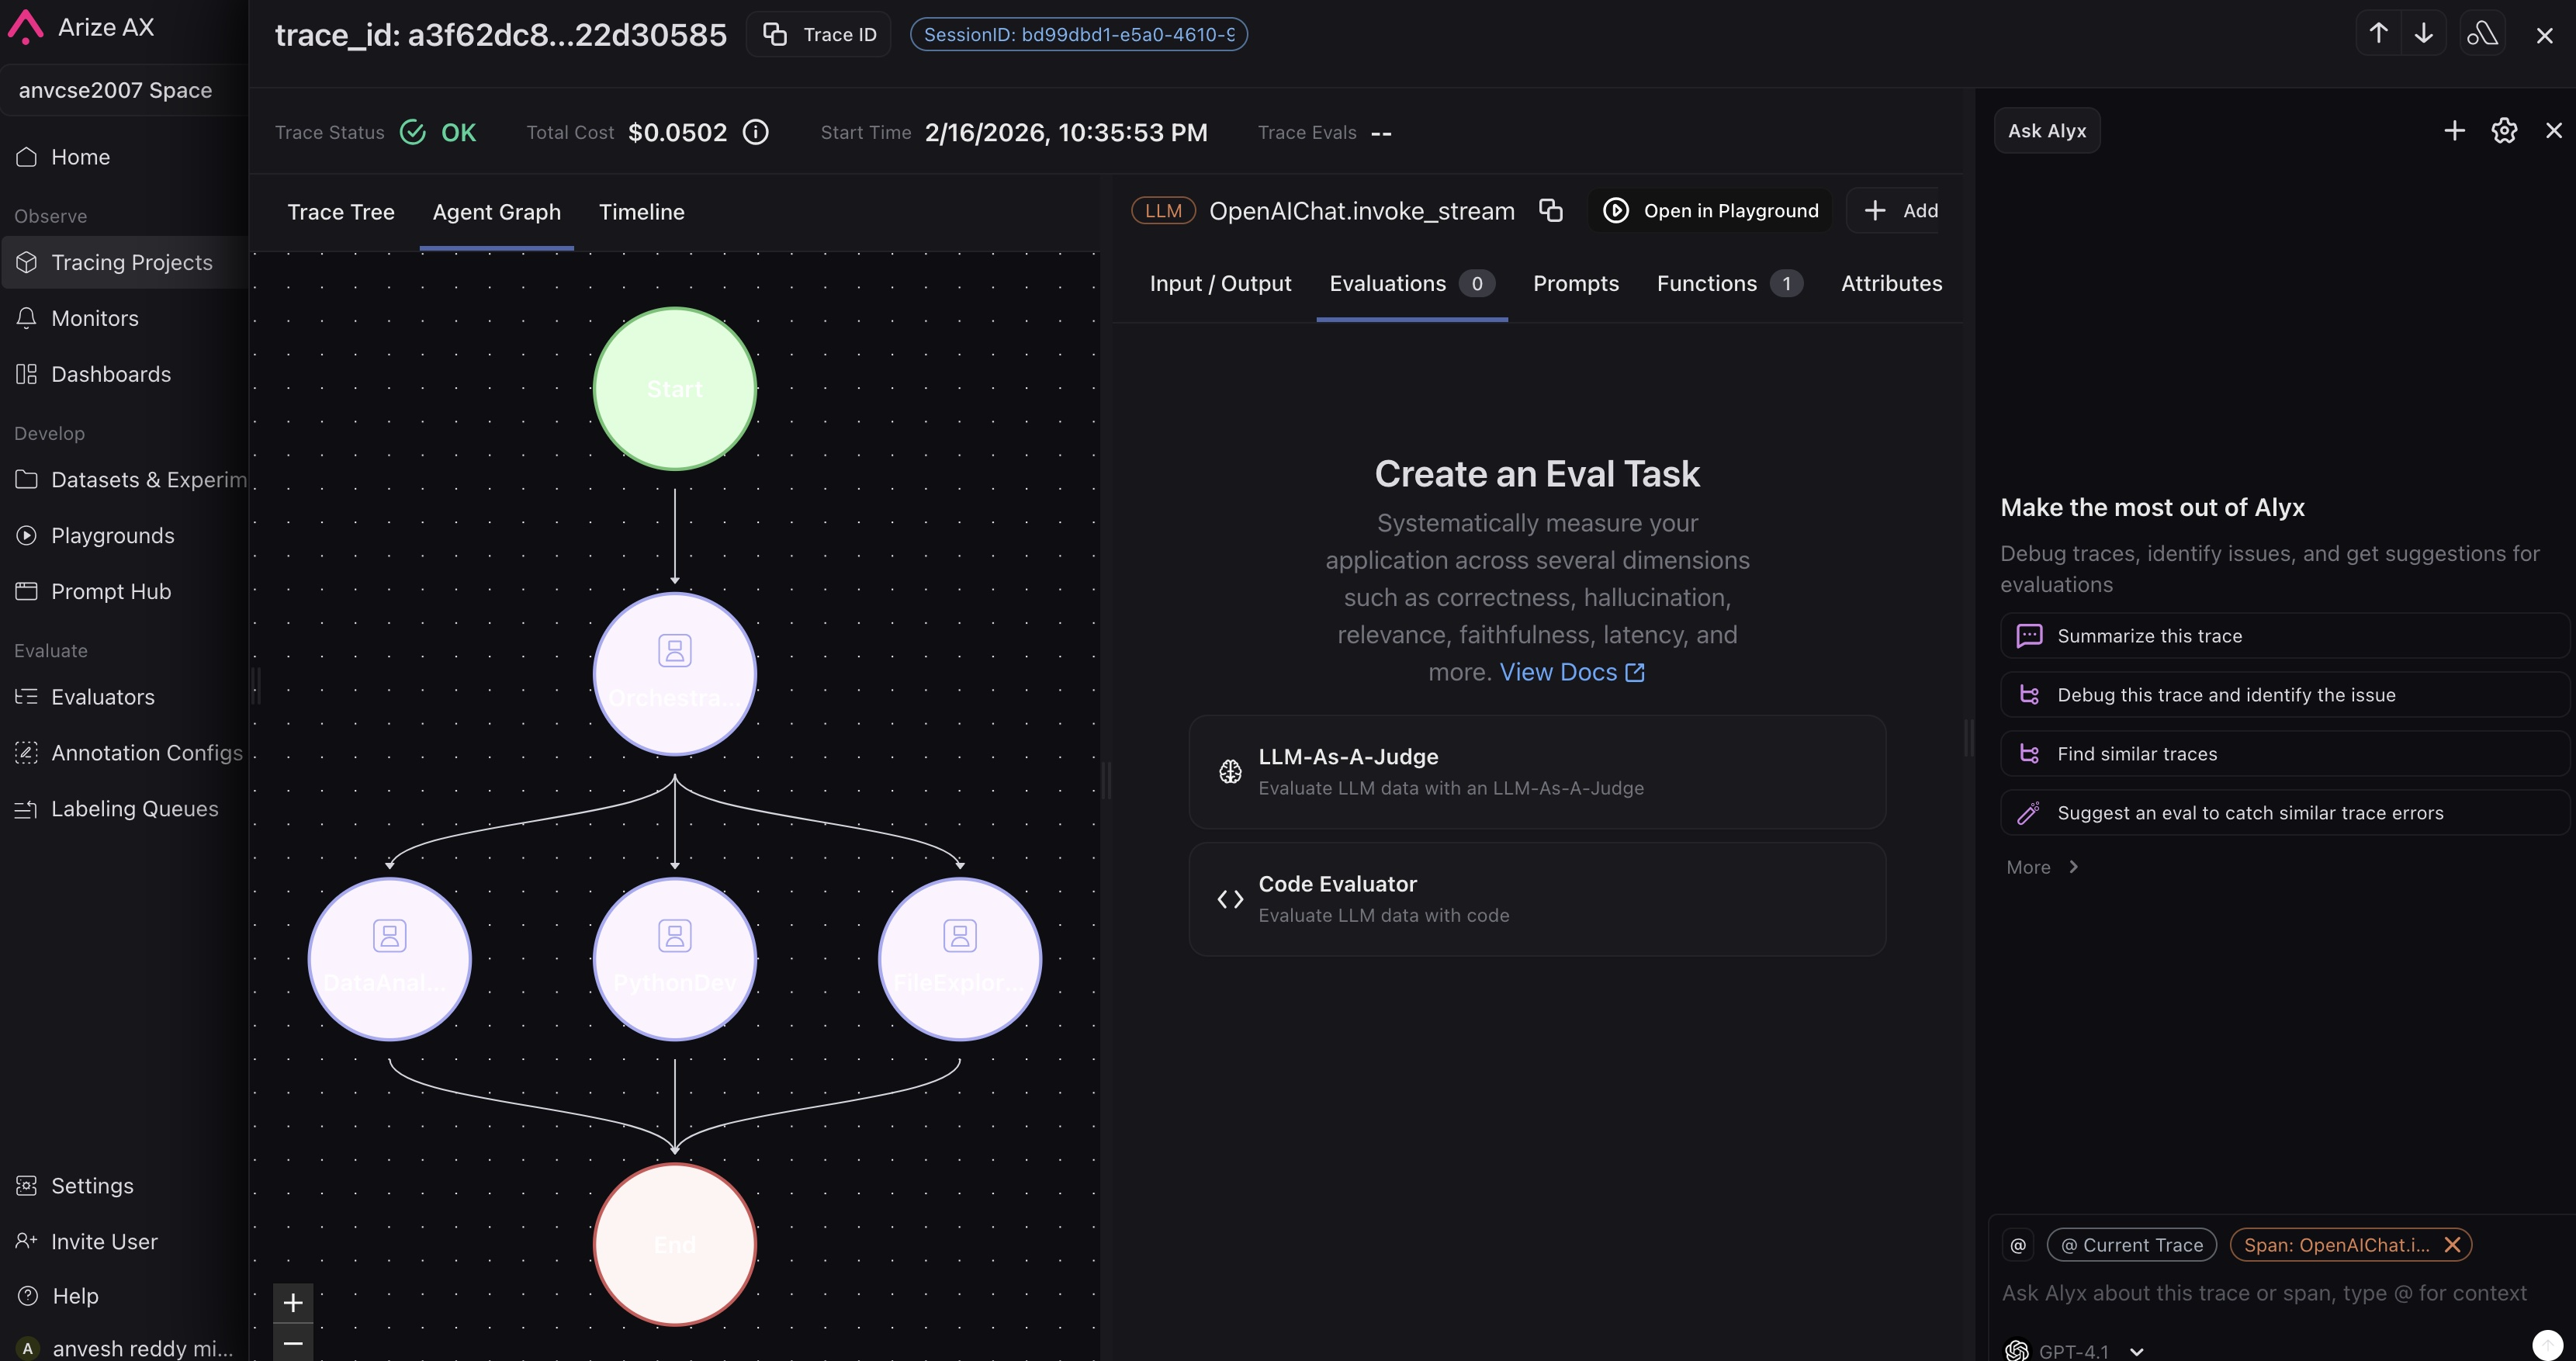